In [1]:
## Importing the required Python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import os
import cv2

In [2]:
## Importing and Loading the dataset folder from the kaggle

!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
import kaggle
!kaggle competitions download -c dogs-vs-cats

100% 809M/812M [00:06<00:00, 188MB/s]
100% 812M/812M [00:06<00:00, 126MB/s]


In [3]:
## Extracting the required data from the dataset folder

!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip
os.rename('test1','test')

In [4]:
## Removing the unwanted files and folders
!rm -rf sampleSubmission.csv train.zip test1.zip dogs-vs-cats.zip

In [5]:
## Making the dataframe for training model with images

df = pd.DataFrame()
df['Imagename'] = os.listdir('train/')
df['Label'] = df['Imagename'].str.split('.',expand=True)[0]
df.sample(10)

,Imagename,Label
21500,dog.9912.jpg,dog
3486,cat.6288.jpg,cat
19792,dog.6552.jpg,dog
20808,dog.1671.jpg,dog
6196,dog.5761.jpg,dog
16310,cat.8960.jpg,cat
18443,cat.3153.jpg,cat
14458,cat.8221.jpg,cat
4609,cat.3466.jpg,cat
7382,dog.12248.jpg,dog


In [6]:
## Making the dataframe for testing model with images

dff = pd.DataFrame()
image_dir = 'test/'
image_names = sorted(os.listdir(image_dir))
dff['Imagename'] = image_names
dff.head(10)

,Imagename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg
5,10001.jpg
6,10002.jpg
7,10003.jpg
8,10004.jpg
9,10005.jpg


In [7]:
## Defining a function for calculating the heights and widths of the training images and storing it in the training dataframe

### Function for calculating height of images
def get_height(filename) :
  image = cv2.cvtColor(cv2.imread('train/'+filename),cv2.COLOR_BGR2RGB)
  return image.shape[0]

### Function for calculating width of images
def get_width(filename) :
  image = cv2.cvtColor(cv2.imread('train/'+filename),cv2.COLOR_BGR2RGB)
  return image.shape[1]

### Applying the above functions to the training dataframe

df['Height'] = df['Imagename'].apply(get_height)
df['Width'] = df['Imagename'].apply(get_width)

df.sample(10)

,Imagename,Label,Height,Width
7342,dog.9997.jpg,dog,374,500
19657,dog.12369.jpg,dog,500,455
12576,dog.10546.jpg,dog,415,500
16889,cat.2651.jpg,cat,356,499
23233,dog.4845.jpg,dog,270,359
3242,cat.10327.jpg,cat,249,250
12003,cat.2898.jpg,cat,375,499
4385,dog.11323.jpg,dog,373,499
3662,dog.9322.jpg,dog,375,499
22102,dog.11273.jpg,dog,396,327


In [8]:
## Calculating the mean height and mean width of the training images

print(f"Mean Height of the Training Images : {np.mean(df['Height'])}")
print(f"Mean Width of the Training Images : {np.mean(df['Width'])}")

Mean Height of the Training Images : 360.47808
Mean Width of the Training Images : 404.09904


In [9]:
## Finding out the total counts of each categories present inside training dataframe

df['Label'].value_counts()

cat    12500
dog    12500
Name: Label, dtype: int64

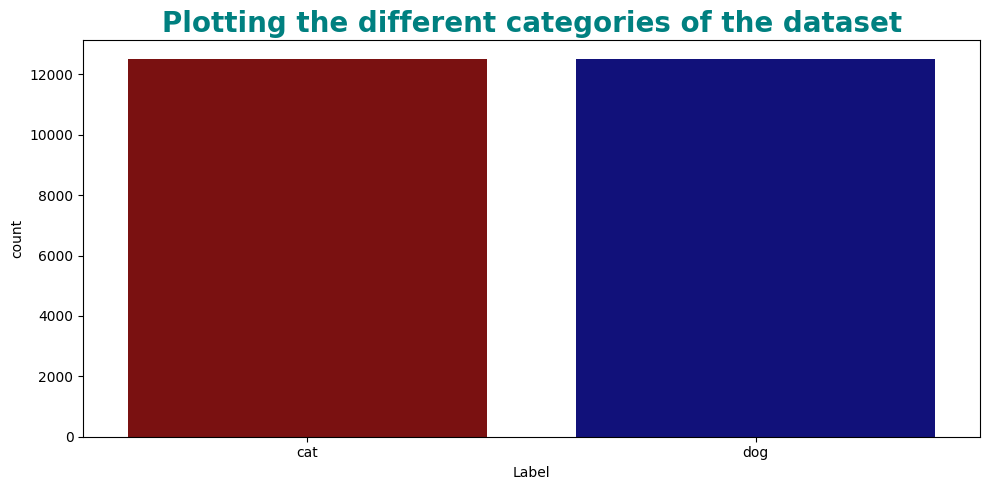

In [10]:
## Plotting the total counts of each categories

plt.figure(figsize=(10,5))
sns.countplot(data=df,x='Label',palette=['darkred','darkblue'])
plt.title("Plotting the different categories of the dataset",weight='black',fontsize=20,color='teal')
plt.tight_layout()
plt.show()

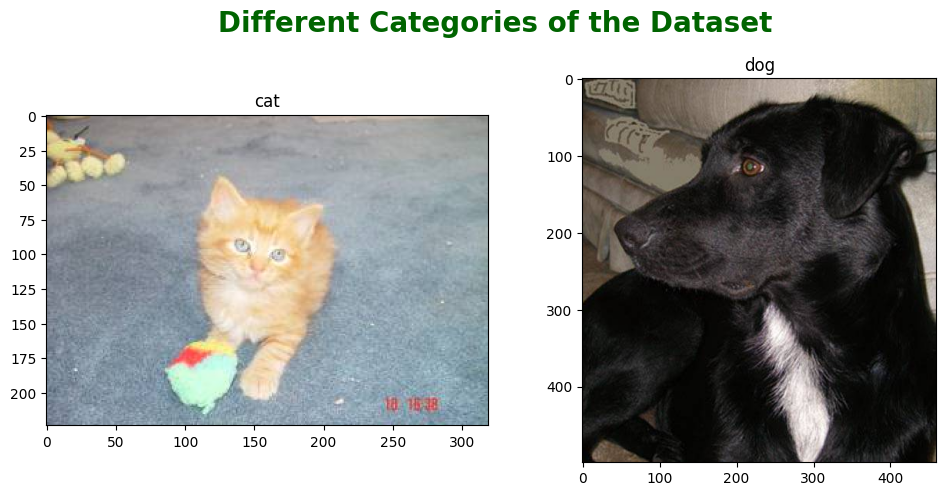

In [11]:
## Plotting the random images of each category

plt.subplots(1,2,figsize=(10,5))
for i,label in enumerate(df['Label'].value_counts().index) :
  plt.subplot(1,2,i+1)
  filename = np.random.choice(df.loc[df['Label']==label]['Imagename'])
  image = cv2.cvtColor(cv2.imread('train/'+filename),cv2.COLOR_BGR2RGB)
  plt.imshow(image)
  plt.title(label,fontsize=12)
plt.suptitle("Different Categories of the Dataset",weight='black',fontsize=20,color='darkgreen')
plt.tight_layout()
plt.show()

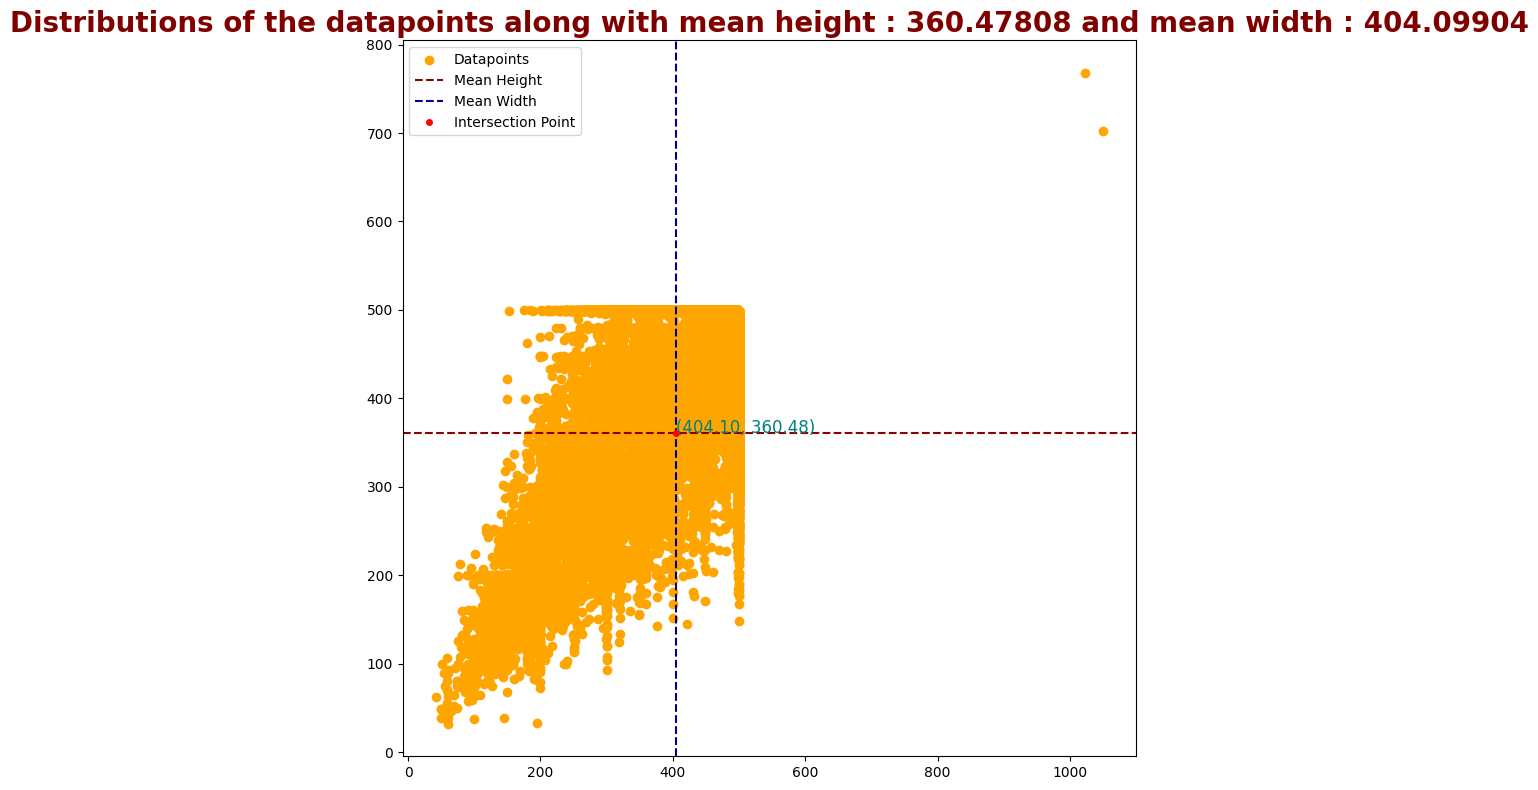

In [12]:
## Plotting the mean height and mean width of the dataset as compared to the datapoints of the dataset
plt.figure(figsize=(8,8))
plt.scatter(data=df,x='Width',y='Height',color = "orange",label="Datapoints")

## Plotting the horizontal as well as vertical lines for mean height and mean width
plt.axhline(y=df['Height'].mean(),linestyle='--',color='darkred',label="Mean Height")
plt.axvline(x=df['Width'].mean(),linestyle='--',color='darkblue',label="Mean Width")

## Plotting the intersection point and coordinates of theat intersection point
plt.plot(df['Width'].mean(),df['Height'].mean(),'ro',markersize=4,label="Intersection Point")
plt.text(df['Width'].mean(),df['Height'].mean(), f"({df['Width'].mean():.2f}, {df['Height'].mean():.2f})", color='teal', fontsize=12, verticalalignment='baseline')

plt.title(f"Distributions of the datapoints along with mean height : {df['Height'].mean()} and mean width : {df['Width'].mean()}",weight='black',fontsize=20,color='maroon')
plt.legend()
plt.tight_layout()
plt.show()

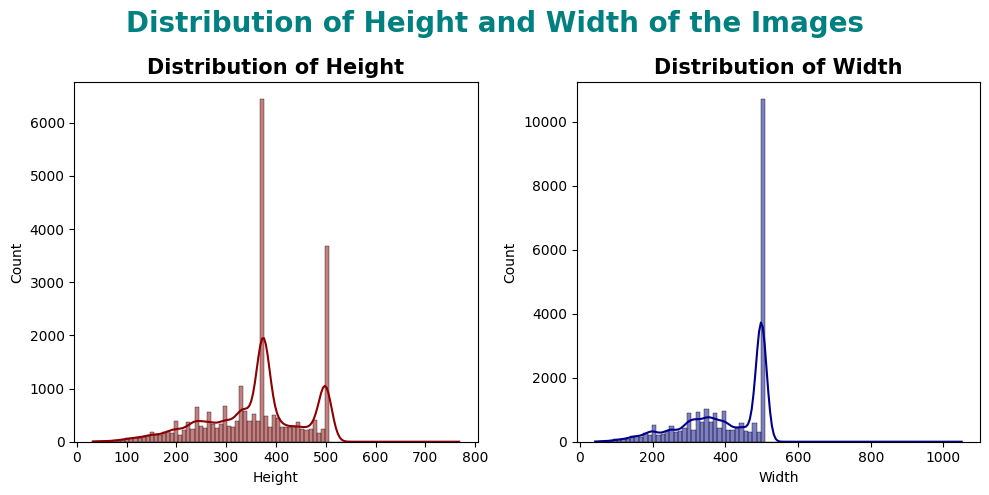

In [13]:
## Plotting the distribution of height and width of the images

plt.subplots(1,2,figsize=(10,5))
plt.subplot(121)
sns.histplot(data=df,x='Height',color='darkred',kde=True)
plt.title("Distribution of Height",fontsize=15,weight='black')
plt.subplot(122)
sns.histplot(data=df,x='Width',color='darkblue',kde=True)
plt.title("Distribution of Width",fontsize=15,weight='black')
plt.suptitle("Distribution of Height and Width of the Images",weight='black',fontsize=20,color='teal')
plt.tight_layout()
plt.show()

In [14]:
## Image Data Generator

idg = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                      vertical_flip=True,
                                                      rotation_range=60,
                                                      rescale=1/255.0,
                                                      validation_split=0.1)

## Training Generator
train_idg = idg.flow_from_dataframe(dataframe=df,directory='train',x_col='Imagename',y_col='Label',target_size=(150,150),batch_size=64,subset='training')
## Validation Generator
val_idg = idg.flow_from_dataframe(dataframe=df,directory='train',x_col='Imagename',y_col='Label',target_size=(150,150),batch_size=64,subset='validation')

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [15]:
## Creating a Convolutional Neural Network Model wiht multiple Convolutional Layers and Pooling Layers

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(150,150,3),name="INPUT"))
### 1st Chunk Layer
model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='valid',strides=(1,1),activation='relu',name="CONV1"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',name="POOL1"))
### 2nd Chunk Layer
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='valid',strides=(1,1),activation='relu',name="CONV2"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',name="POOL2"))
### 3rd Chunk Layer
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='valid',strides=(1,1),activation='relu',name="CONV3"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='valid',name="POOL3"))
model.add(tf.keras.layers.Flatten(name="FLAT"))
model.add(tf.keras.layers.Dense(64,activation='relu',name="HIDDEN"))
model.add(tf.keras.layers.Dense(2,activation='softmax',name="OUTPUT"))

In [16]:
## Displaying the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 148, 148, 16)      448       
                                                                 
 POOL1 (MaxPooling2D)        (None, 74, 74, 16)        0         
                                                                 
 CONV2 (Conv2D)              (None, 72, 72, 32)        4640      
                                                                 
 POOL2 (MaxPooling2D)        (None, 36, 36, 32)        0         
                                                                 
 CONV3 (Conv2D)              (None, 34, 34, 32)        9248      
                                                                 
 POOL3 (MaxPooling2D)        (None, 17, 17, 32)        0         
                                                                 
 FLAT (Flatten)              (None, 9248)              0

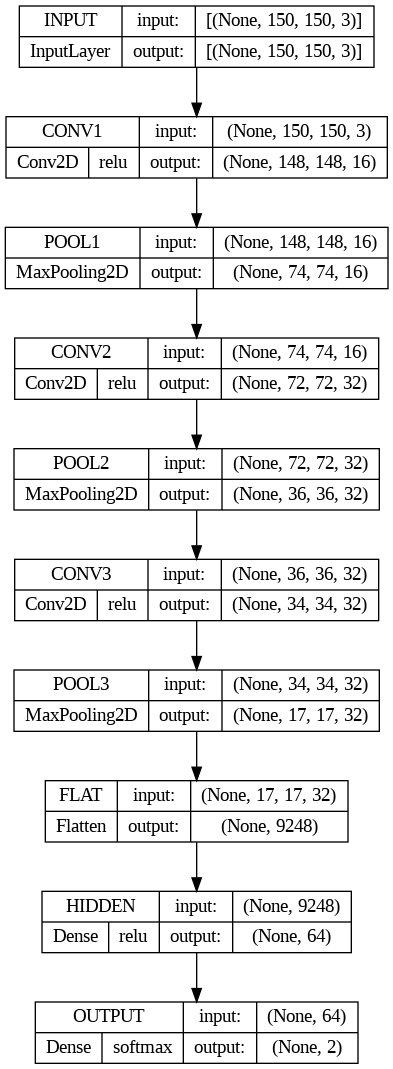

In [17]:
## Plotting the model
tf.keras.utils.plot_model(model,show_layer_names=True,show_shapes=True,show_layer_activations=True)

In [18]:
## Compiling the model
model.compile(optimizer=tf.keras.optimizers.SGD(),loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

## Feeding the model with training images
model.fit(train_idg,epochs=20,batch_size=64,validation_data=val_idg)

Epoch 1/20
352/352 [==============================] - 182s 489ms/step - loss: 0.6868 - accuracy: 0.5421 - val_loss: 0.6794 - val_accuracy: 0.5576
Epoch 2/20
352/352 [==============================] - 170s 482ms/step - loss: 0.6733 - accuracy: 0.5870 - val_loss: 0.6784 - val_accuracy: 0.5648
Epoch 3/20
352/352 [==============================] - 178s 503ms/step - loss: 0.6611 - accuracy: 0.6000 - val_loss: 0.6781 - val_accuracy: 0.5560
Epoch 4/20
352/352 [==============================] - 173s 492ms/step - loss: 0.6487 - accuracy: 0.6152 - val_loss: 0.6548 - val_accuracy: 0.5980
Epoch 5/20
352/352 [==============================] - 166s 471ms/step - loss: 0.6341 - accuracy: 0.6325 - val_loss: 0.6226 - val_accuracy: 0.6480
Epoch 6/20
352/352 [==============================] - 165s 467ms/step - loss: 0.6195 - accuracy: 0.6494 - val_loss: 0.6065 - val_accuracy: 0.6748
Epoch 7/20
352/352 [==============================] - 167s 476ms/step - loss: 0.6093 - accuracy: 0.6644 - val_loss: 0.5972 -

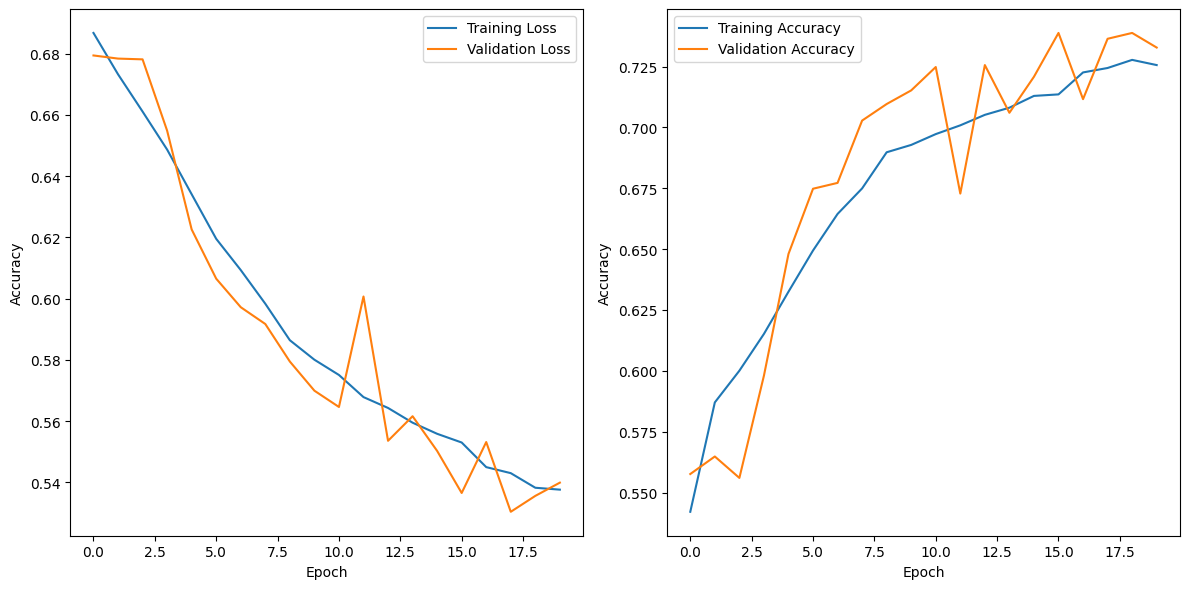

In [19]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(model.history.history['loss'],label="Training Loss")
plt.plot(model.history.history['val_loss'],label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(122)
plt.plot(model.history.history['accuracy'],label="Training Accuracy")
plt.plot(model.history.history['val_accuracy'],label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
np.random.seed(42)
test_images = np.random.choice(os.listdir("test/"),size=500,replace=False)
predictions = []
for imagename in test_images :
  image_path = os.path.join("test/"+imagename)
  image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(150,150))
  image = np.expand_dims(image,axis=0)
  image = image/255.0
  prediction = model.predict(image)
  predictions.append(prediction)

1/1 [==============================] - 0s 24ms/step


In [22]:
for i in range(len(test_images)) :
  if i%20==0 :
    image_path = os.path.join('test/',test_images[i])
    prediction = predictions[i]
    plt.imshow(cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB))
    plt.title("Dog" if prediction[0][1] > prediction[0][0] else "Cat")
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

***In order to improve the model performance as well as decrease the losses, we can do the following :***
  * Take optimizer as Adam instead of SGD
  * Take image of shape (224,224) or (380,380)